## Imports

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

## Load and Clean Data

In [121]:
file_path = 'Case1_Historical.csv'
data = pd.read_csv(file_path)

# Step 3: Data Cleaning and Preparation (if necessary)
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
Unnamed: 0    0
EPT           0
DLO           0
MKU           0
IGM           0
BRV           0
dtype: int64


## Plot Histogram Distributions for Each Asset

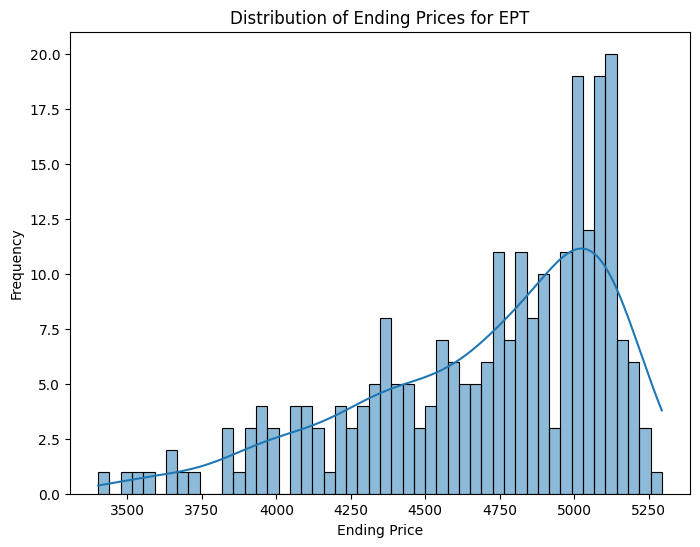

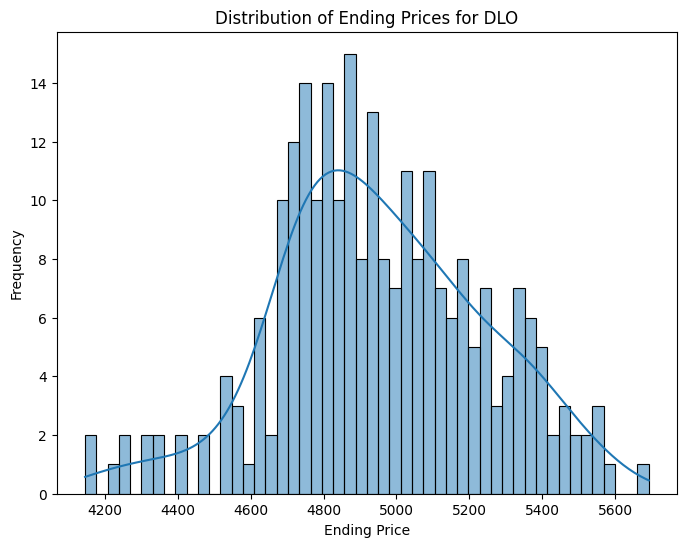

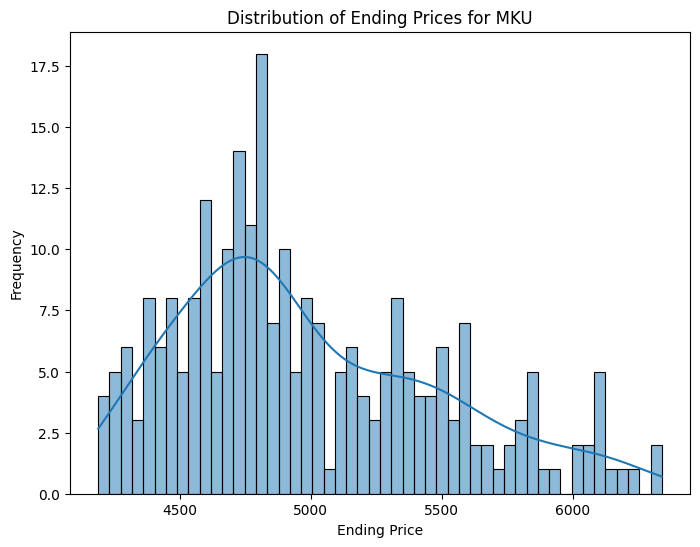

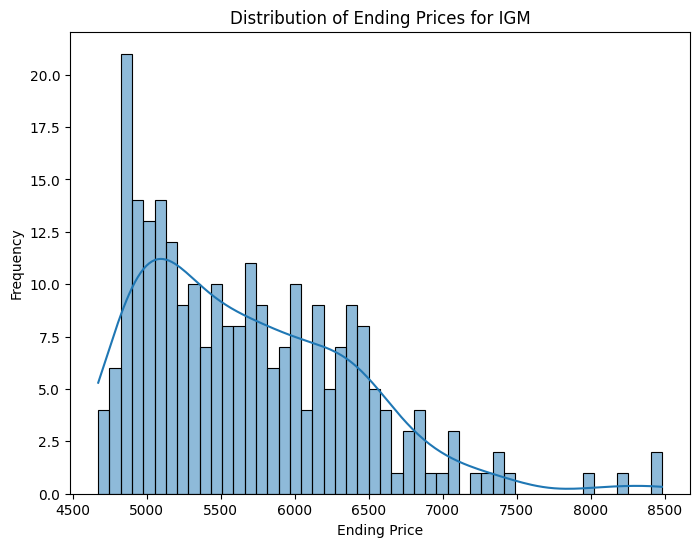

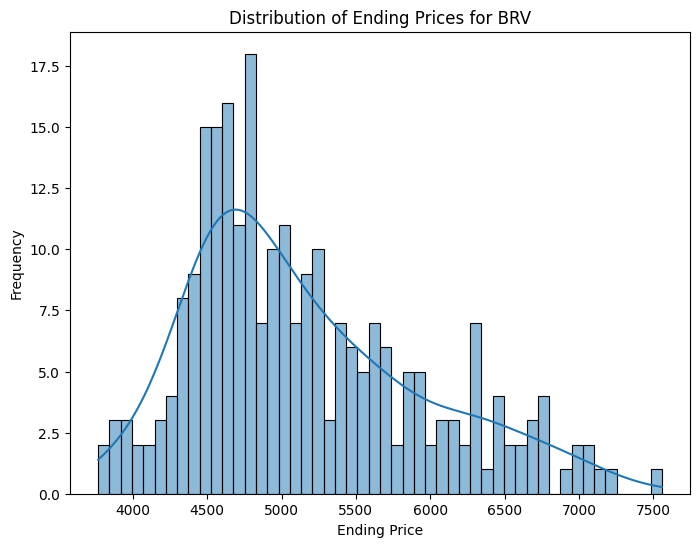

In [122]:
ASSETS = data.columns[1:]
for column in ASSETS:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True, bins=50)
    plt.title(f'Distribution of Ending Prices for {column}')
    plt.xlabel('Ending Price')
    plt.ylabel('Frequency')
    plt.show()


## Use KS Test to Determine which Distribution Data May Follow

In [123]:
from scipy.stats import kstest, gamma, norm, expon, beta, erlang, lognorm

def test_distribution(data, distribution_name):
    """
    Test if the assets in the DataFrame follow a specified distribution.

    Parameters:
        - data: DataFrame containing the assets data
        - distribution_name: Name of the distribution to test

    Returns:
        - A dictionary containing KS statistic and p-value for each asset
    """
    results = {}

    # Iterate over each asset
    for asset_name in data.columns[1:]:
        if distribution_name == 'gamma':
            params = gamma.fit(data[asset_name])
        elif distribution_name == 'norm':
            params = norm.fit(data[asset_name])
        elif distribution_name == 'expon':
            params = expon.fit(data[asset_name])
        elif distribution_name == 'beta':
            params = beta.fit(data[asset_name])
        elif distribution_name == 'erlang':
            params = erlang.fit(data[asset_name])
        elif distribution_name == 'lognorm':
            params = lognorm.fit(data[asset_name])
        else:
            raise ValueError("Unsupported distribution name")

        ks_statistic, p_value = kstest(data[asset_name], distribution_name, args=params)

        # Store results
        results[asset_name] = {'KS Statistic': ks_statistic, 'P-value': p_value}

    return results


distribution_names = ['gamma', 'norm', 'expon', 'beta', 'erlang', 'lognorm']
for distribution_name in distribution_names:
    print("-----------------------------------------")
    print(f"Testing distribution: {distribution_name}")
    results = test_distribution(data, distribution_name)
    alpha = 0.05  # Significance value
    # Print results
    for asset_name, result in results.items():
        print(f"Asset: {asset_name}")
        print("Kolmogorov-Smirnov Test for", distribution_name, "Distribution:")
        print(f"KS Statistic: {result['KS Statistic']}")
        print(f"P-value: {result['P-value']}")
        if result['P-value'] < alpha:
            print(f"Data does NOT follow a {distribution_name} distribution")
        else:
            print(f"Data MAY follow a {distribution_name} distribution")
        print()


-----------------------------------------
Testing distribution: gamma
Asset: EPT
Kolmogorov-Smirnov Test for gamma Distribution:
KS Statistic: 0.46077417893005723
P-value: 1.7695646251242383e-49
Data does NOT follow a gamma distribution

Asset: DLO
Kolmogorov-Smirnov Test for gamma Distribution:
KS Statistic: 0.05213938340066941
P-value: 0.48377384876308593
Data MAY follow a gamma distribution

Asset: MKU
Kolmogorov-Smirnov Test for gamma Distribution:
KS Statistic: 0.04502785880353444
P-value: 0.6693385006124062
Data MAY follow a gamma distribution

Asset: IGM
Kolmogorov-Smirnov Test for gamma Distribution:
KS Statistic: 0.053606998232427094
P-value: 0.4483348398872671
Data MAY follow a gamma distribution

Asset: BRV
Kolmogorov-Smirnov Test for gamma Distribution:
KS Statistic: 0.05656433867108002
P-value: 0.38140726512216927
Data MAY follow a gamma distribution

-----------------------------------------
Testing distribution: norm
Asset: EPT
Kolmogorov-Smirnov Test for norm Distributi

## Fit Assets to Log Normal Distributions

#### KS test revealed that all assetts except for EPT follows a log normal distribution. Fit our data to this distribution and compute the specific CDF parameters

Parameters for the fitted log-normal distribution for DLO:
Shape parameter (s): 2.1419624388701136e-06
Location parameter (loc): -134213581.99999972
Scale parameter (scale): 134218533.6227077


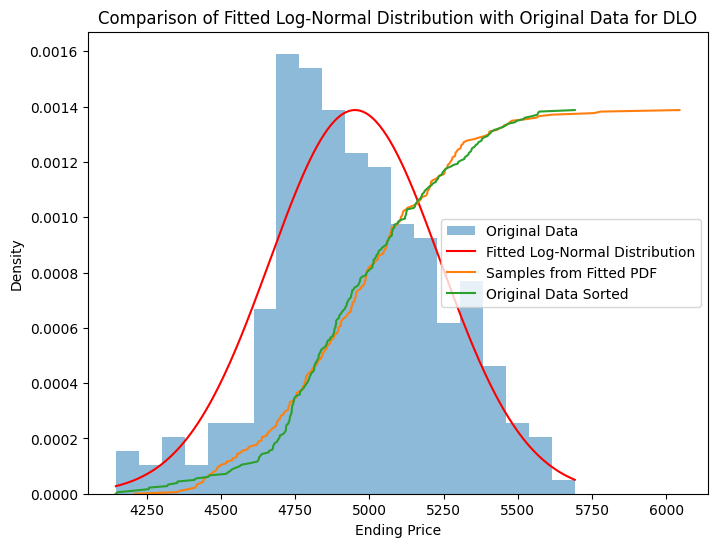

Parameters for the fitted log-normal distribution for MKU:
Shape parameter (s): 0.40270382418182865
Location parameter (loc): 3733.1568842205147
Scale parameter (scale): 1158.1320986157264


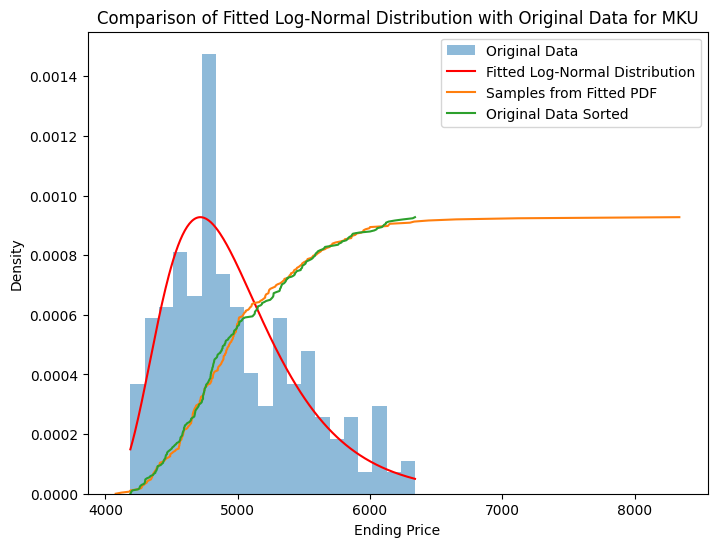

Parameters for the fitted log-normal distribution for IGM:
Shape parameter (s): 0.5958785691616849
Location parameter (loc): 4419.956929025464
Scale parameter (scale): 1075.482212660808


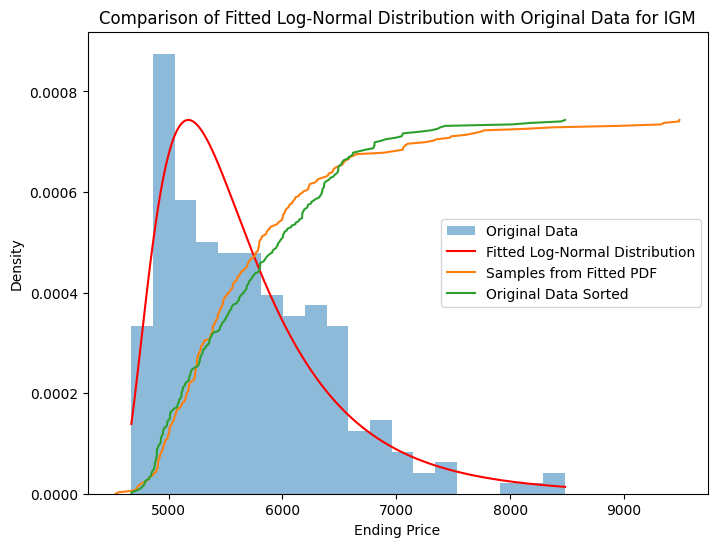

Parameters for the fitted log-normal distribution for BRV:
Shape parameter (s): 0.3678754212094856
Location parameter (loc): 3070.363652275149
Scale parameter (scale): 1947.4387869918887


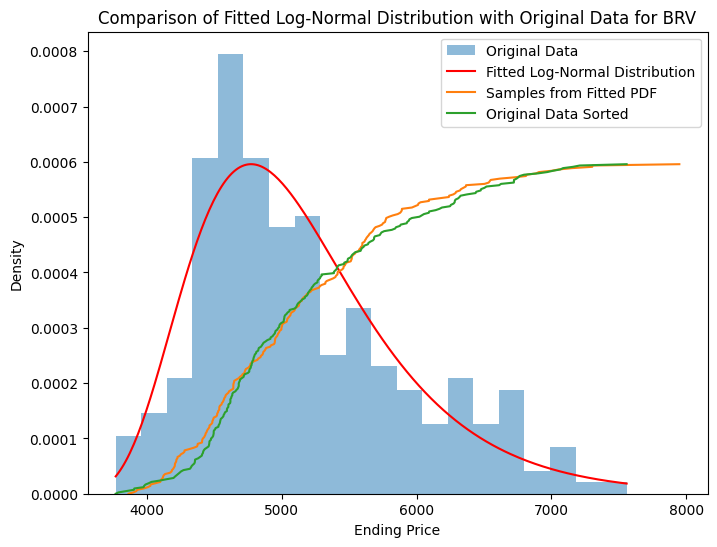

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm


asset_names_except_EPT = [asset_name for asset_name in data.columns[1:] if asset_name != 'EPT']

for asset_name in asset_names_except_EPT:

    params = lognorm.fit(data[asset_name])
    s, loc, scale = params

    print(f"Parameters for the fitted log-normal distribution for {asset_name}:")
    print(f"Shape parameter (s): {s}")
    print(f"Location parameter (loc): {loc}")
    print(f"Scale parameter (scale): {scale}")

    x = np.linspace(data[asset_name].min(), data[asset_name].max(), 252)
    pdf_fitted = lognorm.pdf(x, s, loc, scale)
    plt.figure(figsize=(8, 6))
    plt.hist(data[asset_name], bins=20, density=True, alpha=0.5, label='Original Data')
    plt.plot(x, pdf_fitted, 'r-', label='Fitted Log-Normal Distribution')


    samples = lognorm.rvs(s, loc, scale, size=252)
    samples_sorted = np.sort(samples)
    plt.plot(samples_sorted, np.linspace(0, max(pdf_fitted), 252), label='Samples from Fitted PDF')

    original_sorted = np.sort(data[asset_name])
    plt.plot(original_sorted, np.linspace(0, max(pdf_fitted), 252), label='Original Data Sorted')

    plt.title(f'Comparison of Fitted Log-Normal Distribution with Original Data for {asset_name}')
    plt.xlabel('Ending Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
